<a href="https://colab.research.google.com/github/rishabhvenkat/Model-for-VS/blob/main/VS_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
      Channel_1     Channel_2     Channel_3     Channel_4     Channel_5  \
0  1.655166e-11 -1.169447e-11  5.076939e-12  2.178994e-11  2.497060e-11   
1  1.668334e-06  8.531224e-09 -2.073720e-08 -8.561317e-07  5.097402e-07   
2  3.303607e-06  3.522690e-08  6.069178e-07 -1.569379e-06  9.496465e-07   
3  4.739466e-06  8.715029e-08  2.148850e-06 -2.144098e-06  1.330076e-06   
4  5.727478e-06  1.565227e-07  4.355144e-06 -2.697218e-06  1.716765e-06   

       Time  Epoch  
0  0.000000      1  
1  0.003907      1  
2  0.007814      1  
3  0.011720      1  
4  0.015627      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21373725 entries, 0 to 21373724
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Channel_1  float64
 1   Channel_2  float64
 2   Channel_3  float64
 3   Channel_4  float64
 4   Channel_5  float64
 5   Time   

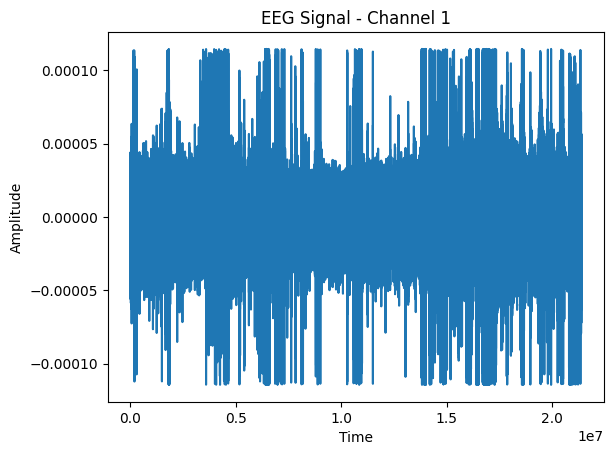

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset in your Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/cleaned_eeg_data.csv'  # Replace with the actual path

# Load the data
data = pd.read_csv(file_path)

# Inspect the data
print(data.head())
print(data.info())
print(data.describe())

# Check for missing values
print(data.isnull().sum())

# Plot a sample channel
channel = 'Channel_1'  # Use the correct column name as shown in your dataset
plt.plot(data[channel])
plt.title('EEG Signal - Channel 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [2]:
from scipy.signal import butter, filtfilt

# Band-pass filter (0.5 - 50 Hz)
def bandpass_filter(signal, lowcut=0.5, highcut=50.0, fs=256, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply band-pass filter to all channels
filtered_data = data.copy()
channels = [col for col in data.columns if "Channel" in col]

for channel in channels:
    filtered_data[channel] = bandpass_filter(data[channel])


In [3]:
# Define parameters
sampling_rate = 256  # Hz (example sampling rate)
window_size = sampling_rate * 1  # 1-second window
segments = []

# Segment the data
for start in range(0, len(filtered_data), window_size):
    segment = filtered_data.iloc[start:start + window_size]
    segments.append(segment)


In [5]:
from scipy.stats import skew, kurtosis
import numpy as np
from scipy.signal import welch

# Bandpower calculation
def bandpower(data, fs, band, window_sec=1):
    fmin, fmax = band
    freqs, psd = welch(data, fs, nperseg=fs * window_sec)
    bandpower = np.trapz(psd[(freqs >= fmin) & (freqs <= fmax)], dx=freqs[1] - freqs[0])
    return bandpower

# Extract features for each segment
def extract_features(segment):
    features = {}
    for channel in channels:
        window = segment[channel].values
        features[f"{channel}_mean"] = np.mean(window)
        features[f"{channel}_variance"] = np.var(window)
        features[f"{channel}_skewness"] = skew(window)
        features[f"{channel}_kurtosis"] = kurtosis(window)
        # Bandpower features
        features[f"{channel}_delta_power"] = bandpower(window, sampling_rate, (0.5, 4))
        features[f"{channel}_theta_power"] = bandpower(window, sampling_rate, (4, 8))
        features[f"{channel}_alpha_power"] = bandpower(window, sampling_rate, (8, 13))
        features[f"{channel}_beta_power"] = bandpower(window, sampling_rate, (13, 30))
    return features

# Generate feature dataframe
feature_data = pd.DataFrame([extract_features(segment) for segment in segments])


/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 29, using nperseg = 29
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


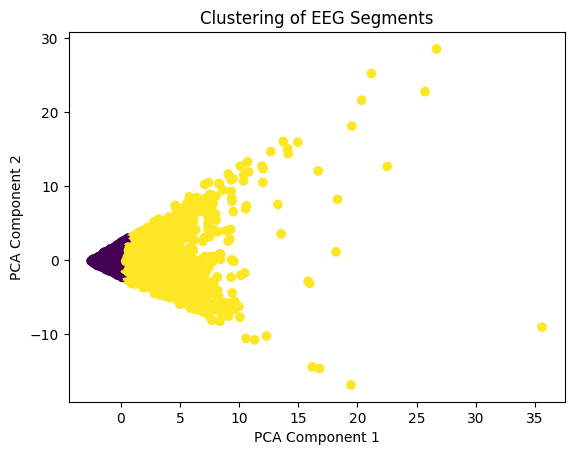

In [6]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(feature_data)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Visualize clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title("Clustering of EEG Segments")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
